In [1]:
using Pkg
Pkg.add(["PyPlot","UMAP","LinearAlgebra","Distributions","Random","Flux","Zygote","SpecialFunctions","StatsBase","BoltzmannMachines","Statistics","DelimitedFiles"])
Pkg.add(url="https://github.com/ssehztirom/LogLinearModels.jl")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `/Users/moritz/Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.7/Pkg/src/manifest.jl:287
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/moritz/Manifest.toml:0
    Updating git-repo `https://github.com/ssehztirom/LogLinearModels.jl`
   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [2]:
using PyPlot
using UMAP
using LinearAlgebra
using Distributions
using Random
using Flux
using Zygote
using SpecialFunctions
using LogLinearModels
using StatsBase
using BoltzmannMachines
using Statistics
using DelimitedFiles

In [3]:
include("patternextractor.jl")

makeconstraint (generic function with 2 methods)

# Code for training VAEs

In [4]:
# Principal component analysis (PCA)

function standardize2(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize2(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end


struct VAE
	encoder
	mu
	logsigma
	decoder
end

# struct XYZ
#    encoder

function bernoulliloss(xhat,x)
	ce(x,y) =  y * log(x + eps()) + (1 - y) * log(1 - x + eps())
	# logpdf(b::Bernoulli,y::Bool) = y * log(b.p + eps()) + (1-y) * log(1-b.p + eps())
	# return sum(Distributions.logpdf.(Bernoulli.(xhat),x))
	return sum(ce.(xhat,x))
end

    
function normalz(mu,logsigma)
	return mu  + exp(logsigma) * randn()
end



function kullbackleiblerqp(mu,logsigma)
	return 0.5 * sum(exp.(2 .* logsigma) + mu.^2 .- 1 .- 2 .* logsigma)
end


g(x) = (h = vae.encoder(x); (vae.mu(h), vae.logsigma(h)))	

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [5]:
function posteriorsample(x) 
    mu,logsigma = g(x)
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

function priorsample(x) 
    mu,logsigma = g(x)
    mu = zeros(length(mu))
    logsigma = zeros(length(logsigma))
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

priorsample (generic function with 1 method)

# Code for simulated data

In [6]:
n = 250
a = 2
b = -2

-2

In [7]:
g1c1z1 = rand(Normal(a,1),n)
g1c2z1 = rand(Normal(b,1),n)
g1c1z2 = rand(Normal(a,1),n)
g1c2z2 = rand(Normal(a,1),n)

g2c1z2 = rand(Normal(a,1),n)
g2c2z2 = rand(Normal(b,1),n)
g2c1z1 = rand(Normal(a,1),n)
g2c2z1 = rand(Normal(a,1),n)


250-element Vector{Float64}:
 1.2039710413011375
 3.5327429029622417
 1.6726004299030808
 2.7875707931650697
 0.881433113196634
 1.9003595563880626
 3.038460623294851
 2.1501138694897417
 2.671522407935708
 2.3570370119488735
 0.7476787318000986
 1.0978372633489177
 3.0408093586826954
 ⋮
 3.055087083502703
 2.8287855071775554
 1.571892384524395
 1.8044245775580028
 0.8687545542082322
 1.8520300107613545
 2.7679406061160834
 1.6278554980581947
 0.3831136369674195
 0.9646834011916878
 0.8601501150818309
 1.1987919819163775

In [8]:
z1 = cat([g1c1z1,g1c2z1,g2c1z1,g2c2z1]...,dims=1)
z2 = cat([g1c1z2,g1c2z2,g2c1z2,g2c2z2]...,dims=1)

1000-element Vector{Float64}:
  1.8184942630173857
  0.7637253788361589
  3.2465375361314104
  1.0321871616858873
  3.8875011579559065
  1.148957238505334
  2.796171603298033
  2.6294765910086784
  1.5820976395838733
  2.049013434050526
  1.796531824016129
  2.781740355984476
  0.9640885366903182
  ⋮
 -2.142941188835961
 -1.9177628865658674
 -1.5157776648004353
 -1.8621313832042234
 -2.531633171207438
 -1.7120079905854269
 -2.306974449719923
 -2.4111008289302363
 -1.3081270360254795
 -1.4097464471183079
 -1.1250176743398748
 -0.8085046338021342

In [9]:
cellfactor = cat([fill(1,n),fill(2,n),fill(1,n),fill(3,n)]...,dims=1)
groupfactor = cat([fill(1,n*2),fill(2,n*2)]...,dims=1)

1000-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [10]:
col = ["r","deepskyblue"]
gcols = col[groupfactor]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor]

1000-element Vector{String}:
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 ⋮
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"

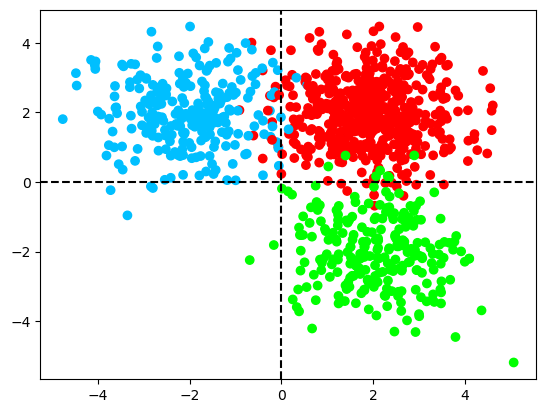

PyObject <matplotlib.lines.Line2D object at 0x18cd57bb0>

In [11]:
PyPlot.scatter(z1,z2,c=ccols)
PyPlot.axhline(y = 0.0,c="black",linestyle="--")
PyPlot.axvline(x = 0.0,c="black",linestyle="--")

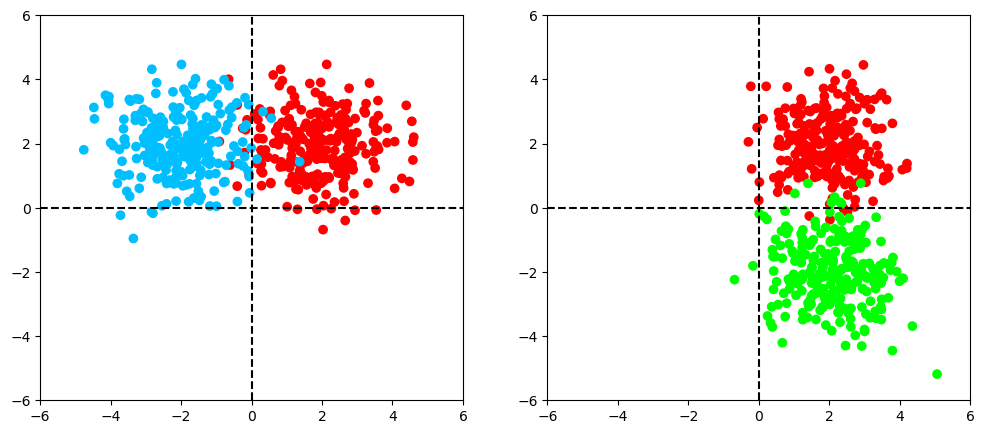

PyObject <matplotlib.lines.Line2D object at 0x18cfa52e0>

In [12]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
g1i = groupfactor .== 1
ax[1].scatter(z1[g1i],z2[g1i],c=ccols[g1i])
ax[1][:set_ylim]([-6,6])
ax[1][:set_xlim]([-6,6])
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
g2i = groupfactor .== 2
ax[2].scatter(z1[g2i],z2[g2i],c=ccols[g2i])
ax[2][:set_ylim]([-6,6])
ax[2][:set_xlim]([-6,6])
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [13]:
x = zeros(n*4,10)

1000×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.

In [14]:
for i=1:5
    x[:,i] = z1 + rand(Normal(0,1),n*4)
end

In [15]:
for i=6:10
    x[:,i] = z2 + rand(Normal(0,1),n*4)
end

In [16]:
x01 = convert(Array{Float64,2},ifelse.(x.>0,1,0))

1000×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮                   
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.

In [17]:
noisevars = convert(Array{Float64,2},rand(1000,20) .> 0.5)

1000×20 Matrix{Float64}:
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  …  1.0  1.0  0.0  0.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  1.0  0.0  1.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0     1.0  0.0  0.0  1.0  0.0  1.0  1.0
 0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0     0.0  1.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  …  0.0  1.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0

In [18]:
x01 = hcat([x01,noisevars]...)

1000×30 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  0.0  0.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  1.0  0.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     0.0  1.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  1.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

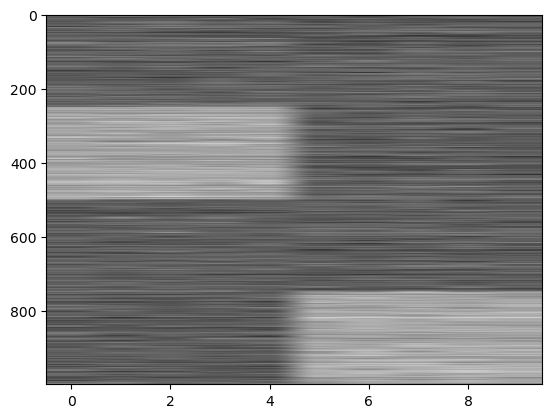

PyObject <matplotlib.image.AxesImage object at 0x18d022430>

In [19]:
PyPlot.imshow(x,aspect="auto",cmap="binary")

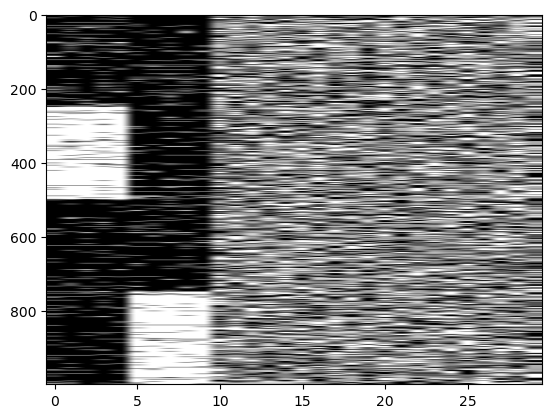

PyObject <matplotlib.image.AxesImage object at 0x18d07e310>

In [20]:
PyPlot.imshow(x01,aspect="auto",cmap="binary")

## Simulated Data Ready, prepare for training VAE

In [21]:
n,p = size(x01)

(1000, 30)

In [22]:
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [23]:
testdata

368-element Vector{Adjoint{Float64, Matrix{Float64}}}:
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [0.0; 0.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [0.0; 0.0; … ; 1.0; 0.0;;]
 ⋮
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 0.0;;]
 [0.0; 0.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [0.0; 0.0; … ; 0.0; 0.0;;]
 [0.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]

In [24]:
col = ["lightgrey","k"]
gcols = col[groupfactor[testidx]]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor[testidx]]

368-element Vector{String}:
 "lime"
 "lime"
 "r"
 "deepskyblue"
 "r"
 "r"
 "r"
 "r"
 "r"
 "lime"
 "r"
 "r"
 "deepskyblue"
 ⋮
 "lime"
 "lime"
 "deepskyblue"
 "deepskyblue"
 "deepskyblue"
 "r"
 "deepskyblue"
 "deepskyblue"
 "r"
 "lime"
 "deepskyblue"
 "r"

# Train VAE

In [25]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end




In [26]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

1

In [27]:
loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [28]:
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

VAE(Chain(Dense(30, 30, tanh)), Dense(30, 2), Dense(30, 2), Chain(Dense(2, 30, relu), Dense(30, 30, σ)))

In [29]:
optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)

Params([Float32[-0.21166883 -0.036679838 … -0.09168885 0.094487116; 0.050509237 0.23434964 … 0.27464327 -0.031743303; … ; -0.02800931 -0.13444553 … 0.2145687 0.22609095; 0.1939767 0.22877489 … -0.16312665 0.2823618], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.23465197 0.22051999 … 0.07838469 -0.034903724; 0.21626312 0.045496177 … -0.36964485 0.0015206997], Float32[0.0, 0.0], Float32[-0.42893928 0.370592 … 0.11676181 -0.32878834; 0.25255343 -0.03477674 … 0.225178 0.16739601], Float32[0.0, 0.0], Float32[0.1933963 0.06880604; 0.36454853 0.33934513; … ; 0.34757817 0.2702324; 0.3253124 0.11031515], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.14380309 -0.3017917 … 0.063717805 -0.0048677; 0.09285279 -0.01082798 … -0.13923407 0.11875712; … ; -0.31188414 0.052131128 … -0.29600835 0.16998582; 0.1445122 0.17016178 … -0.30094182 0.26255414], 

Write a custom training loop

In [30]:
losslist = []
for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end


# Check output from VAE

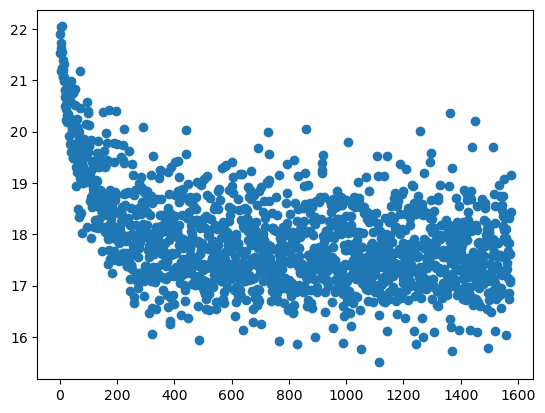

PyObject <matplotlib.collections.PathCollection object at 0x18d1ec220>

In [31]:
PyPlot.scatter(collect(1:length(losslist)),losslist)

## Plot expected value of latent variables

In [32]:
zs = Transpose(cat(dims=2,map(x-> x[1],g.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
 -0.473159     -0.298981
 -0.702459     -1.28486
 -0.551637      1.24558
  1.57217      -0.54011
 -0.355563      1.21323
 -0.342868      0.600993
 -0.390534      1.13676
 -0.484339      1.20615
  0.000230731   1.30996
 -1.00666      -0.861972
 -0.464518      1.16889
 -9.85968e-5    0.544076
  1.3422        0.947828
  ⋮            
 -0.518789     -0.896099
  1.13419      -1.60105
  1.8333        0.2195
  1.7681        0.32482
 -0.252952      1.10397
 -0.132537      0.604979
  1.61252       0.593203
  1.474         0.539528
 -0.253864      1.15009
 -0.743717     -1.02666
  1.30176       0.816079
  0.426706      0.840514

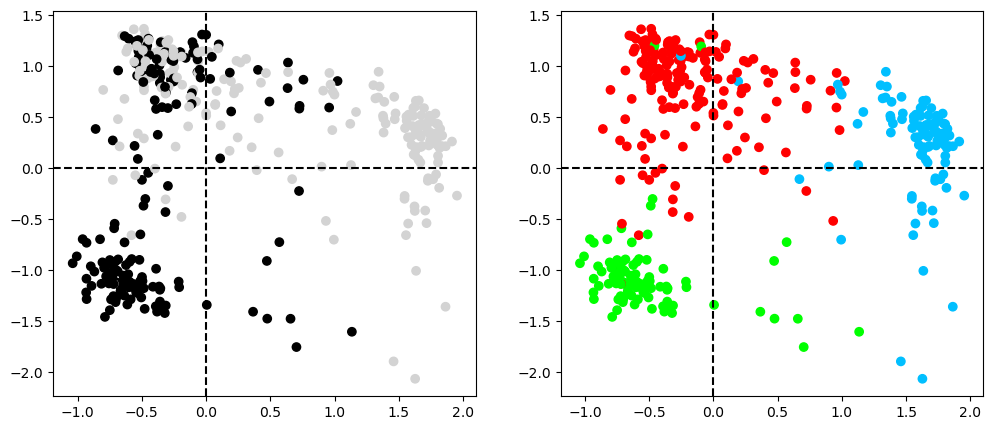

PyObject <matplotlib.lines.Line2D object at 0x18d2a9a90>

In [33]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [34]:
zs = Transpose(cat(dims=2,map(x-> x[1],posteriorsample.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
  0.0178782    0.185761
 -1.52242     -1.49032
  0.425084     0.488736
  2.03705     -0.760432
 -0.181041     0.256
 -0.278637     0.74959
 -0.00273676   0.404132
 -0.953509     1.22594
  0.203335     1.94744
 -1.03518     -0.473932
 -0.118983     0.972094
 -0.0124746    0.601245
  0.763066     1.41019
  ⋮           
  0.795183    -0.162211
  0.964692    -2.26399
  2.09417      1.1885
  1.73704     -0.596889
 -0.423879     0.518467
  0.239174     1.25111
  1.4011      -0.0337871
  1.39479     -0.117429
 -0.242604     0.237169
  0.142008    -1.17106
  0.962238     0.109577
  0.683524     0.538522

## Left labelled according to group, right labelled according to celltype

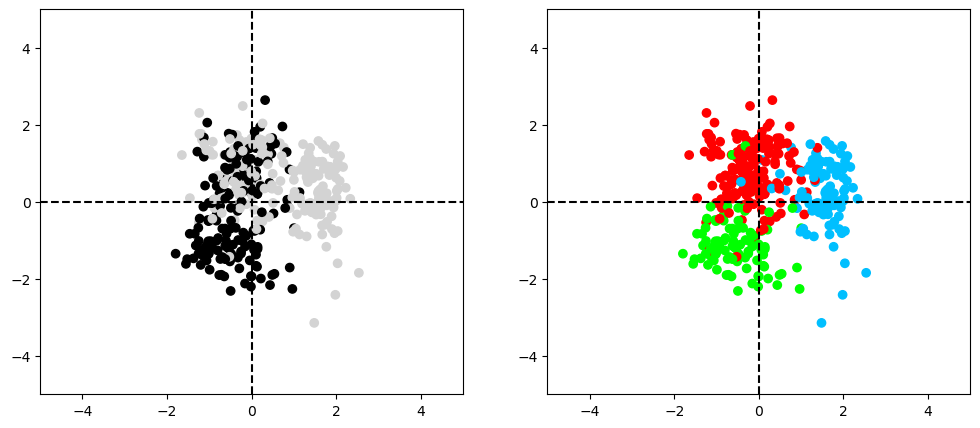

PyObject <matplotlib.lines.Line2D object at 0x2224ed520>

In [35]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 5
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

# Draw samples from trained VAE

In [36]:
vaesamples = priorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.8269663245760153, -0.6543917092606906], [0.28897932004732585, 0.26163020981951723, 0.26033432307139664, 0.2813387417659667, 0.23299421026017017, 0.7623121148490971, 0.8197444214518589, 0.6961168434418304, 0.7090725513553525, 0.7240485542372395  …  0.5205217421676387, 0.5484283768690985, 0.525191066984837, 0.5411920483009391, 0.45539556348200844, 0.5077171391542686, 0.47059999687367543, 0.4632022868373846, 0.5292015504038454, 0.5269840519666146])
 ([0.2961307245636859, -1.1629161916276305], [0.7013456085214388, 0.717229334211569, 0.7585934201399009, 0.722036101811661, 0.7297098875133562, 0.22115929726918093, 0.23294382831844168, 0.17025144912474144, 0.17047502754636354, 0.19697611714807514  …  0.5176742953452906, 0.5358331636045895, 0.5618969784348629, 0.532017436195392, 0.4750833843405446, 0.5387168510423637, 0.4512057021752175, 0.470864890703615, 0.5604502293461766, 0.5414234765925658])
 ([0.4724494433146802, -1.780194

In [37]:
vaepostsamples = posteriorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.010615985197520661; 0.14413339976759043;;], [0.912518970877217; 0.913543020590637; … ; 0.507308705073794; 0.521681817675946;;])
 ([0.3707262249976848; -1.1145071178838069;;], [0.6525389222340098; 0.6622907912300283; … ; 0.561206099644239; 0.5435802657125455;;])
 ([-1.3362552959425416; 0.5398623632899774;;], [0.9936792049523241; 0.9958897832176878; … ; 0.44108562889851255; 0.5287091914946273;;])
 ([1.3043080509229439; -0.0324886338583229;;], [0.10034445662828866; 0.07614099691899834; … ; 0.45415570523002197; 0.48377033113750884;;])
 ([-0.9535504705349862; 0.7398946687587258;;], [0.9897139485203753; 0.9916770234512491; … ; 0.46210034028878905; 0.5204201988192075;;])
 ([-0.4807651349750277; 1.2812298323746867;;], [0.9856140189873679; 0.98218029185495; … ; 0.4639657177689012; 0.48208028575421474;;])
 ([-0.7953977708771642; 1.2473042518177213;;], [0.9910564382691793; 0.9906755454043844; … ; 0.45815886839968; 0.49236315033986

In [38]:
vaesamples = vaepostsamples

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.010615985197520661; 0.14413339976759043;;], [0.912518970877217; 0.913543020590637; … ; 0.507308705073794; 0.521681817675946;;])
 ([0.3707262249976848; -1.1145071178838069;;], [0.6525389222340098; 0.6622907912300283; … ; 0.561206099644239; 0.5435802657125455;;])
 ([-1.3362552959425416; 0.5398623632899774;;], [0.9936792049523241; 0.9958897832176878; … ; 0.44108562889851255; 0.5287091914946273;;])
 ([1.3043080509229439; -0.0324886338583229;;], [0.10034445662828866; 0.07614099691899834; … ; 0.45415570523002197; 0.48377033113750884;;])
 ([-0.9535504705349862; 0.7398946687587258;;], [0.9897139485203753; 0.9916770234512491; … ; 0.46210034028878905; 0.5204201988192075;;])
 ([-0.4807651349750277; 1.2812298323746867;;], [0.9856140189873679; 0.98218029185495; … ; 0.4639657177689012; 0.48208028575421474;;])
 ([-0.7953977708771642; 1.2473042518177213;;], [0.9910564382691793; 0.9906755454043844; … ; 0.45815886839968; 0.49236315033986

In [39]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

3680×30 transpose(::Matrix{Float64}) with eltype Float64:
 0.912519   0.913543   0.925269   0.904914   …  0.506234  0.507309  0.521682
 0.652539   0.662291   0.704869   0.669689      0.470549  0.561206  0.54358
 0.993679   0.99589    0.997296   0.994324      0.542036  0.441086  0.528709
 0.100344   0.076141   0.0656903  0.0970359     0.442163  0.454156  0.48377
 0.989714   0.991677   0.993986   0.989671      0.531834  0.4621    0.52042
 0.985614   0.98218    0.985979   0.983451   …  0.526694  0.463966  0.48208
 0.991056   0.990676   0.992971   0.990283      0.535653  0.458159  0.492363
 0.879477   0.880964   0.893246   0.870242      0.503844  0.506905  0.518019
 0.972196   0.97014    0.975996   0.969091      0.514772  0.482171  0.505788
 0.96689    0.987122   0.990862   0.982174      0.49419   0.494607  0.527727
 0.993861   0.9928     0.994615   0.993128   …  0.542281  0.447011  0.475391
 0.966727   0.965387   0.971985   0.963286      0.511474  0.487011  0.511622
 0.207778   0.139201  

# Dichotomize samples 
You could also use the dichotomize function to cut the samples at a given quantile if you trained the VAE with count data.

In [40]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

3680×30 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  0.0  1.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0

## Infer Patterns between latent variables and observed variables with log-linear models

In [41]:
nvars = 12

12

In [42]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([1935.539522093688, 1698.7639163086455, 530.9405262422933, 453.28693716635377, 258.2915230356625, 225.50068774870732, 174.52197704420084, 146.1819917635923, 131.7582683683955, 137.83594810932576, 77.03753446626433, 97.57404051390112], [2, 8, 9, 3, 10, 5, 7, 1, 4, 6, 26, 25], Any[[1591.570410315709 0.1998621974471675; 1935.539522093688 2.822501590711269; … ; 2.1398778224252126 6.418079416432022; 2.5780767733004737 2.676562029850494], [335.85949600075924 4.772991529533638; 0.0 0.0; … ; 5.821127868552269 6.313007409604253; 1.8486352300551019 3.1587313348278983], [334.39764437843843 40.34482506421303; 0.0 0.0; … ; 5.834316325568754 4.936890463085831; 3.9216481806165717 6.046411362603489], [336.3773226026434 50.896737099621305; 0.0 0.0; … ; 12.634249590484242 8.819395068278872; 8.551268752491215 9.858805650321107], [166.82578299087737 41.01867399527222; 0.0 0.0; … ; 15.047703062552298 19.35022527000803; 11.110074588310038 22.778696954229492], [167.46874534374697 49.90149964343787; 0.0 0.0;

## Inspect the G-Squared matrix for each selected variable
The Matrix indicates the G-Squared statistic used for selecting a variable at a given iteration (here 12 iterations evaluated).
In the below stated example, g-squared matrix for iteration 6 (based on which the 6th variable is selected) is shown.

In [43]:
res[1]

12-element Vector{Float64}:
 1935.539522093688
 1698.7639163086455
  530.9405262422933
  453.28693716635377
  258.2915230356625
  225.50068774870732
  174.52197704420084
  146.1819917635923
  131.7582683683955
  137.83594810932576
   77.03753446626433
   97.57404051390112

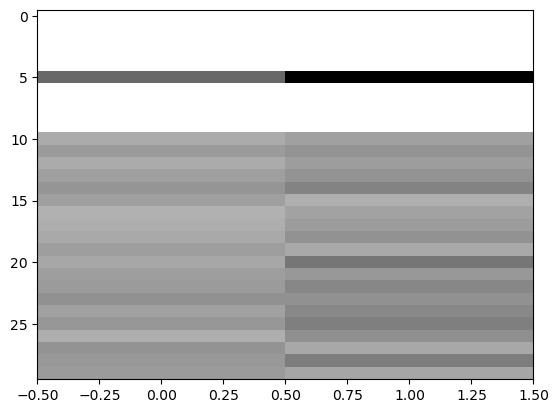

PyObject <matplotlib.image.AxesImage object at 0x224a5c580>

In [44]:
ax = PyPlot.imshow(res[3][10],aspect="auto",cmap="binary")

## Here we infer the labels for the synthetic observations drawn from a VAE based on testdata.

In [45]:
yhat = annotatesamplesbypattern(Transpose(hcat(testdata...)),xsbin[1:500,:],res[2],ccols)

500-element Vector{String}:
 "r"
 "r"
 "deepskyblue"
 "lime"
 "deepskyblue"
 "r"
 "r"
 "r"
 "r"
 "lime"
 "r"
 "r"
 "deepskyblue"
 ⋮
 "r"
 "r"
 "deepskyblue"
 "deepskyblue"
 "lime"
 "r"
 "lime"
 "r"
 "r"
 "lime"
 "lime"
 "lime"

## Here we inspect how synthetic observations were labeled

In [46]:
pzs = zs[1:500,:]

500×2 Matrix{Float64}:
  0.010616     0.144133
  0.370726    -1.11451
 -1.33626      0.539862
  1.30431     -0.0324886
 -0.95355      0.739895
 -0.480765     1.28123
 -0.795398     1.2473
  0.116951     0.074107
 -0.349997     0.734196
 -1.13755     -1.46243
 -0.839637     1.61214
 -0.308365     0.594409
  1.24674      1.12097
  ⋮           
  0.00653209   0.172226
  1.97642     -0.196363
  1.47063      0.128452
  1.03337      0.29804
 -0.526337    -1.29478
  0.15766      0.0881783
 -0.837688    -0.305099
 -0.934937     0.857062
  0.534779    -0.805445
  1.24465     -0.419857
  0.764006    -0.170664
  0.776271     0.73201

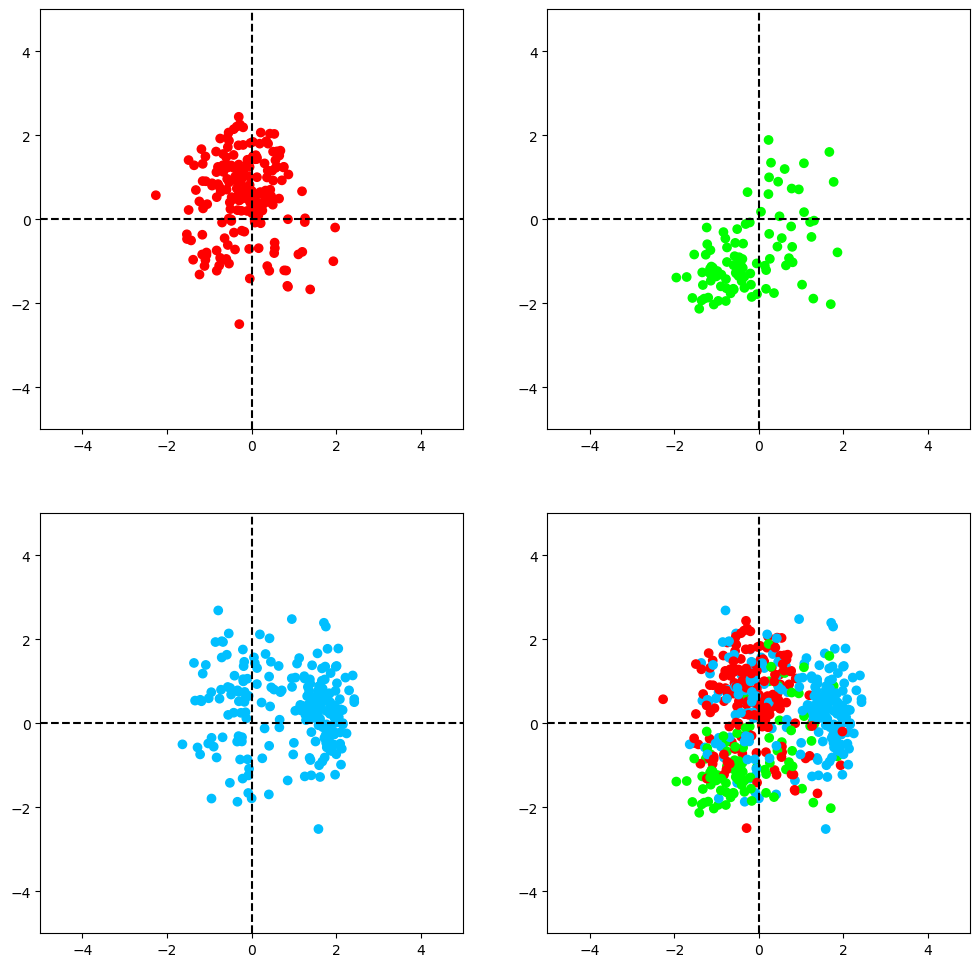

PyObject <matplotlib.lines.Line2D object at 0x224b94f10>

In [47]:
fig, ax = PyPlot.subplots(nrows=2, ncols=2, figsize=(12, 12))
scalepar = 5
ax[1].scatter(pzs[yhat.=="r",1],pzs[yhat.=="r",2],c=yhat[yhat.=="r"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pzs[yhat.=="deepskyblue",1],pzs[yhat.=="deepskyblue",2],c=yhat[yhat.=="deepskyblue"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pzs[yhat.=="lime",1],pzs[yhat.=="lime",2],c=yhat[yhat.=="lime"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pzs[:,1],pzs[:,2],c=yhat)
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

## Now with Tasic et al. data

In [48]:
x = readdlm("data/single_cell_mat.txt",'\t')'

1525×180 adjoint(::Matrix{Float64}) with eltype Float64:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                       

In [49]:
x01 = dichotomize(x)

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.

In [50]:
n,p = size(x01)
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [51]:
Random.seed!(1234)
Dh = 30
Dh2 = 10
Dz = 2
epochs = 500
learningrate = 0.004
batchsize=10
Beta =1

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh),Flux.Dense(Dh,Dh2,tanh)),
    Flux.Dense(Dh2,Dz),
    Flux.Dense(Dh2,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end




In [52]:
vaesamples = priorsample.(vcat([testdata for i = 1:5]...))

2805-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([1.3596261370724443, 1.2490688929677063], [0.9363829402396368, 0.01927776119286933, 0.28061093957349886, 0.21794461703544316, 0.05119531287077134, 0.608407003875518, 0.004982730938668921, 0.2795827123329808, 0.49469583576732623, 0.0071638378175214075  …  0.0005087997634012747, 0.019898356280452147, 0.008385421523283065, 0.0886285222984372, 0.10195114850732397, 0.0075300462171203515, 0.06324027937005952, 0.00042831452512481695, 0.000425409651706142, 0.00669864379621794])
 ([1.0606884911744159, 1.1929644078558859], [0.9207991350116029, 0.03341003878990266, 0.2818686381178798, 0.2560765116895359, 0.04811568972314398, 0.6504779059220156, 0.00923049163080936, 0.3153648526781733, 0.5097112454384743, 0.010514842987478843  …  0.0008883424327430064, 0.01949901332208292, 0.012668257967184801, 0.10083806369278053, 0.14437889444484409, 0.010109594196584977, 0.07038301934353187, 0.0009325926531174861, 0.0009947227000593377, 0.009977229

In [53]:
length(vaesamples)

2805

In [54]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

2805×180 transpose(::Matrix{Float64}) with eltype Float64:
 0.936383     0.0192778  0.280611  0.217945    …  0.00042541   0.00669864
 0.920799     0.03341    0.281869  0.256077       0.000994723  0.00997723
 0.68081      0.607163   0.301223  0.258983       0.0868848    0.0753408
 0.456773     0.364483   0.515798  0.106896       0.0147745    0.0449409
 0.00028609   0.3951     0.984868  0.0033015      8.6473e-5    0.00321057
 0.730734     0.498556   0.260482  0.274083    …  0.0459981    0.0337928
 0.717889     0.420002   0.357928  0.245024       0.0457933    0.0779666
 0.769447     0.250094   0.389248  0.131857       0.00904104   0.0459999
 0.000305935  0.443044   0.975218  0.00586235     0.000221306  0.00388545
 0.254373     0.282434   0.67023   0.0389449      0.0023408    0.023803
 0.799076     0.286864   0.315384  0.315041    …  0.0255482    0.0515037
 0.204113     0.245688   0.722639  0.0247891      0.000981183  0.0179593
 0.92561      0.0381083  0.243107  0.370179       0.00147716  

In [55]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

2805×180 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.

In [56]:
nvars = 8

8

In [57]:
y = readdlm("data/celltype.txt")[:,1]

1525-element Vector{Any}:
 "Vip"
 "Vip"
 "L4"
 "Vip"
 "Vip"
 "L2/3"
 "L2"
 "L2/3"
 "L4"
 "L2"
 "Pvalb"
 "L2/3"
 "Vip"
 ⋮
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"

## Select variables

In [58]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([989.3942009587754, 671.7826763069547, 443.02598187943374, 326.59163225790627, 298.8640818905589, 220.2317522161224, 205.24480182438288, 192.77411273925526], [150, 1, 155, 84, 37, 88, 27, 71], Any[[195.13648331026354 564.6522701291126; 352.2979314379788 5.5146939843502025; … ; 52.88374120329541 25.77486723743475; 12.21736010736889 7.966667574049151], [121.02438885570677 671.7826763069547; 112.16933179753849 76.91958338923304; … ; 20.124117413459594 19.045940009386232; 2.762259374497405 8.010959697558517], [0.0 0.0; 92.53416328961616 35.1339511002971; … ; 24.002697402211684 25.352967782914387; 5.304264144042568 8.478703296167563], [0.0 0.0; 97.43795213048836 45.27411688536644; … ; 30.15095018843738 24.32097662749095; 10.472784893866914 11.098203038942772], [0.0 0.0; 74.38720722240154 48.13005254657941; … ; 23.577350886893562 29.503678340351254; 11.33008501946715 21.580123298387484], [0.0 0.0; 86.49131252301557 57.46530896699206; … ; 29.752113951514772 27.03102099197809; 24.865717826079

## Annotate synthetic observations

In [59]:
yhat = annotatesamplesbypattern(x01,xsbin[1:1000,:],res[2],y)

1000-element Vector{String}:
 "Sst"
 "L6a"
 "L6a"
 "Pvalb"
 "Vip"
 "Pvalb"
 "L5a"
 "L6a"
 "Vip"
 "Vip"
 "L5b"
 "Vip"
 "L2"
 ⋮
 "L6a"
 "Sst"
 "L6a"
 "Pvalb"
 "L6a"
 "L6a"
 "Sst"
 "Vip"
 "Pvalb"
 "L5a"
 "L6a"
 "Pvalb"

## Compute principal components of synthetic data for plotting

In [60]:
pcs = prcomps(xsbin[1:1000,:])[:,1:2]

1000×2 Matrix{Float64}:
 -3.60474    0.769283
 -3.50351    0.469584
 -1.94803   -1.30422
  0.694116   1.87377
  3.35716    2.70503
 -0.447035  -2.80334
 -4.04565   -0.336949
 -2.1724     0.301394
  4.60085    1.7998
  2.26487    2.06627
 -2.40964    0.420734
  2.09403    2.97918
 -2.37223   -0.157272
  ⋮         
 -4.12056    0.126528
  4.50796    3.23309
 -1.81566    3.32193
 -0.231934  -4.78918
 -0.86264    1.36703
 -0.880161   3.15432
  0.606527   1.15161
  3.78189   -1.12224
  3.28103    0.228567
 -3.88256   -2.56323
 -2.44487   -0.00134725
  0.312218  -2.44707

In [61]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "forestgreen",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "forestgreen"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

In [62]:
cols = [md[i] for i = y]

1525-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "turquoise"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "green"
 "lightgrey"
 "turquoise"
 "green"
 "orangered"
 "lightgrey"
 "darkviolet"
 ⋮
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"

In [63]:
hatcols = [md[i] for i = yhat]

1000-element Vector{String}:
 "gold"
 "lightgrey"
 "lightgrey"
 "orangered"
 "darkviolet"
 "orangered"
 "forestgreen"
 "lightgrey"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "darkviolet"
 "green"
 ⋮
 "lightgrey"
 "gold"
 "lightgrey"
 "orangered"
 "lightgrey"
 "lightgrey"
 "gold"
 "darkviolet"
 "orangered"
 "forestgreen"
 "lightgrey"
 "orangered"

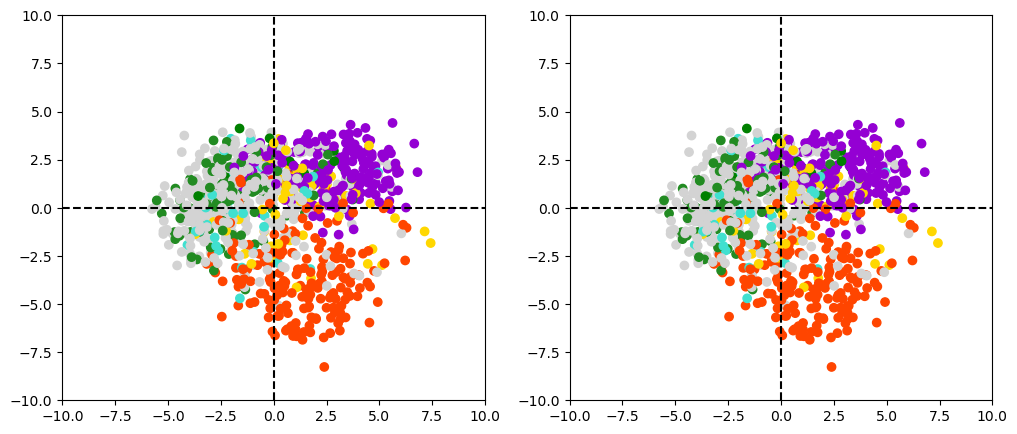

PyObject <matplotlib.lines.Line2D object at 0x22e28aa30>

In [64]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

## Plotting separately for individual cell types

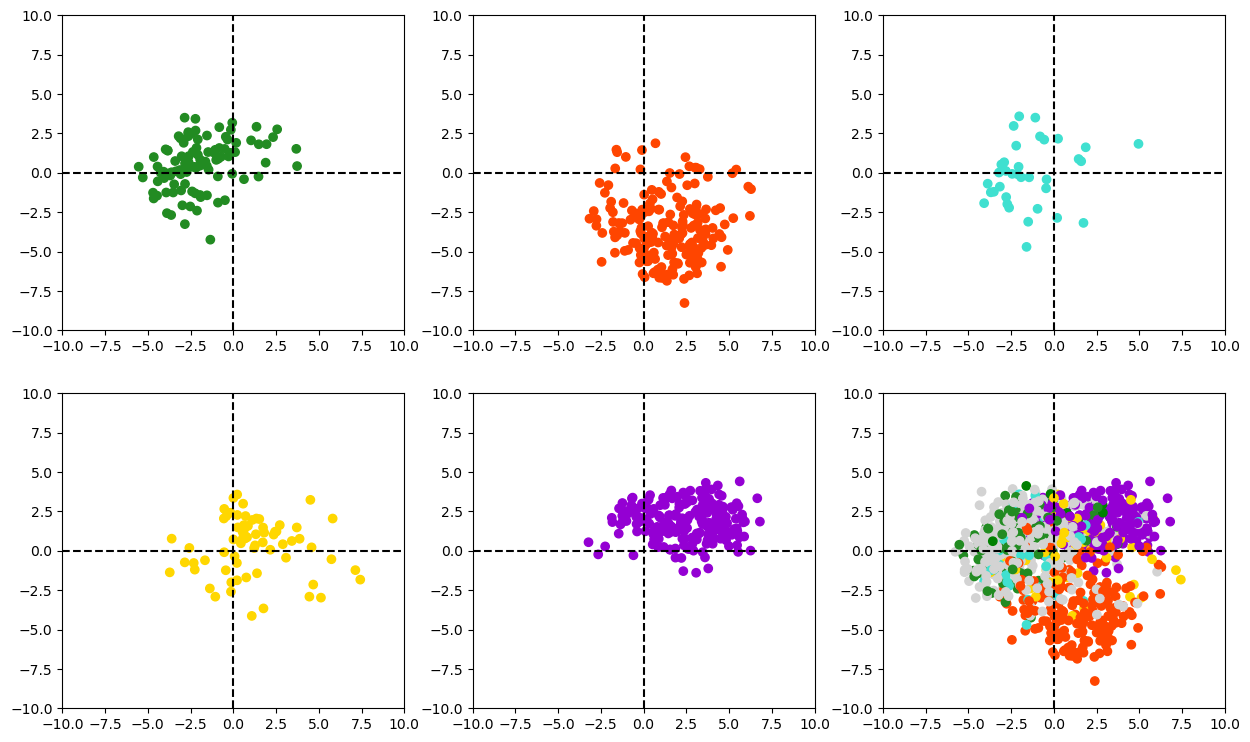

PyObject <matplotlib.lines.Line2D object at 0x22e49b8e0>

In [65]:
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 10
ax[1].scatter(pcs[hatcols.=="forestgreen",1],pcs[hatcols.=="forestgreen",2],c=hatcols[hatcols.=="forestgreen"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pcs[hatcols.=="gold",1],pcs[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pcs[hatcols.=="orangered",1],pcs[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pcs[hatcols.=="darkviolet",1],pcs[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(pcs[hatcols.=="turquoise",1],pcs[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")

In [66]:
zs = Transpose(cat(dims=2,map(x-> x[1],g.(testdata))...))

561×2 transpose(::Matrix{Float64}) with eltype Float64:
 -0.729248  -1.22255
 -0.158566  -1.77831
 -1.46588    0.632
 -1.5483     0.857587
  0.505049   0.510892
 -0.480642  -1.91661
 -0.126059  -1.93677
  1.04694   -0.357277
  1.76964   -0.435409
 -0.310927  -0.791634
 -0.261192  -0.729029
  0.494466   1.51271
  0.913081   0.0582569
  ⋮         
  0.493813   1.57895
  0.663584   0.410659
  0.993291   0.810558
  0.832235  -1.57925
  1.10844    1.78126
 -1.88702    0.948641
 -1.75932   -0.243533
 -0.062773  -2.07913
 -0.796335  -0.909961
  1.8554    -0.640525
 -0.628697  -0.753302
  2.24998   -0.514038

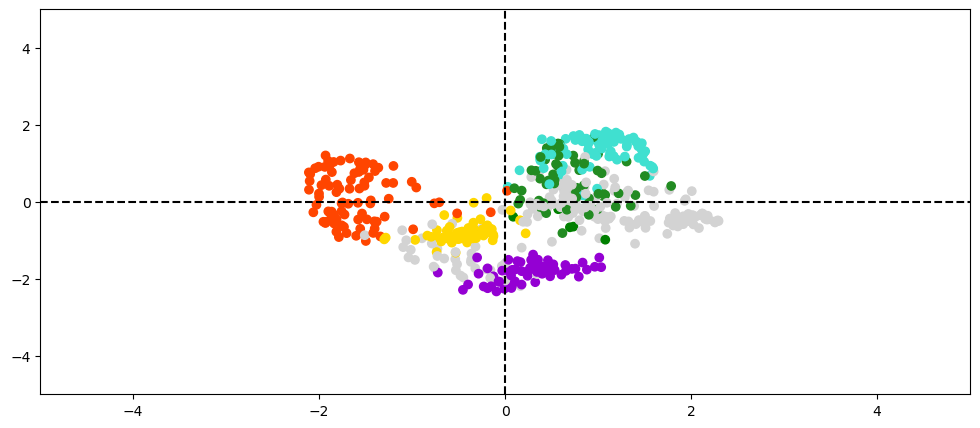

PyObject <matplotlib.lines.Line2D object at 0x22e2d2d00>

In [67]:
fig, ax = PyPlot.subplots(nrows=1, ncols=1, figsize=(12, 5))
scalepar = 5
ax.scatter(zs[:,1],zs[:,2],c=cols[testidx])
ax.set_xlim(-scalepar,scalepar)
ax.set_ylim(-scalepar,scalepar)
ax.axhline(y = 0.0,c="black",linestyle="--")
ax.axvline(x = 0.0,c="black",linestyle="--")